## Classical Logistic Regression → Quantum Variational Classifier

(Strategic decision as classification)


In [1]:
%pip install pennylane pennylane-lightning torch scikit-learn matplotlib

Note: you may need to restart the kernel to use updated packages.


### Cell 1 — Imports & Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import pennylane as qml

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


### Cell 2 — Dataset (Shared, Controlled)

In [3]:
X, y = make_classification(
    n_samples=400,
    n_features=4,
    n_informative=4,
    n_redundant=0,
    n_classes=2,
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


Torch conversion (for quantum model):

In [4]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32)

y_train_t = torch.tensor(2 * y_train - 1, dtype=torch.float32)
y_test_t  = torch.tensor(2 * y_test  - 1, dtype=torch.float32)


### Cell 3 — Progress Axis (SVM-STYLE)

We vary training set size, exactly like the SVM notebook.

In [5]:
TRAIN_SIZES = np.linspace(20, len(X_train), 10, dtype=int)


### Cell 4 — Metrics Template (IDENTICAL STRUCTURE)

In [6]:
metrics_classical = {
    "progress": [],
    "performance": []
}

metrics_quantum = {
    "progress": [],
    "performance": []
}


## CLASSICAL LOGISTIC REGRESSION

### Cell 5 — Classical Evaluation Loop (WITH METRICS)

In [7]:
for size in TRAIN_SIZES:
    clf = LogisticRegression(max_iter=500)
    clf.fit(X_train[:size], y_train[:size])

    predictions = clf.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)

    metrics_classical["progress"].append(size)
    metrics_classical["performance"].append(accuracy)


## QUANTUM VARIATIONAL CLASSIFIER

### Cell 6 — Quantum Circuit Definition

In [8]:
N_QUBITS = 4
dev = qml.device("default.qubit", wires=N_QUBITS)

@qml.qnode(dev, interface="torch")
def vqc(x, weights):
    qml.AngleEmbedding(x, wires=range(N_QUBITS))
    qml.StronglyEntanglingLayers(weights, wires=range(N_QUBITS))
    return qml.expval(qml.PauliZ(0))


### Cell 7 — Quantum Evaluation Loop (WITH METRICS)

For each training size, we:

1. re-initialize the quantum model

2. train for a fixed number of epochs

3. evaluate accuracy on the same test set

This mirrors classical retraining exactly.

In [9]:
EPOCHS = 20

for size in TRAIN_SIZES:
    weights = torch.nn.Parameter(torch.randn(3, N_QUBITS, 3))
    optimizer = torch.optim.Adam([weights], lr=0.1)

    X_sub = X_train_t[:size]
    y_sub = y_train_t[:size]

    # Training
    for _ in range(EPOCHS):
        for x, y in zip(X_sub, y_sub):
            loss = (vqc(x, weights) - y) ** 2
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Evaluation
    preds = []
    for x in X_test_t:
        preds.append(torch.sign(vqc(x, weights)).item())

    accuracy = np.mean(np.array(preds) == y_test_t.numpy())

    metrics_quantum["progress"].append(size)
    metrics_quantum["performance"].append(accuracy)


### Cell 8 — Performance Comparison Plot

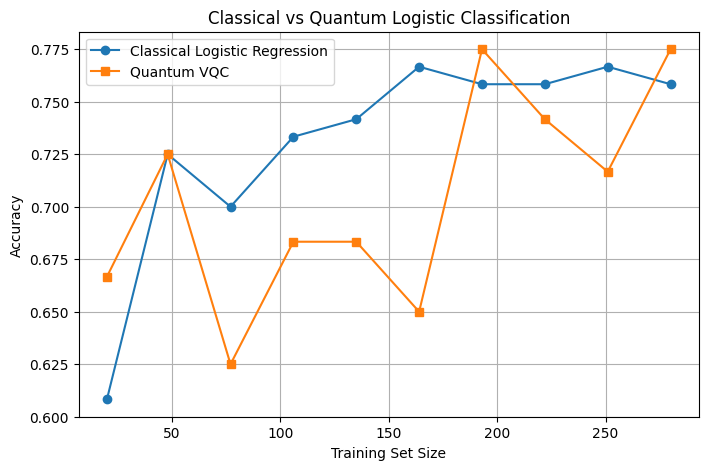

In [10]:
plt.figure(figsize=(8, 5))

plt.plot(
    metrics_classical["progress"],
    metrics_classical["performance"],
    marker="o",
    label="Classical Logistic Regression"
)

plt.plot(
    metrics_quantum["progress"],
    metrics_quantum["performance"],
    marker="s",
    label="Quantum VQC"
)

plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Classical vs Quantum Logistic Classification")
plt.legend()
plt.grid(True)
plt.show()


### Cell 9 — Final Results Table

In [11]:
results = pd.DataFrame({
    "Model": ["Classical Logistic Regression", "Quantum VQC"],
    "Average Accuracy": [
        np.mean(metrics_classical["performance"]),
        np.mean(metrics_quantum["performance"])
    ],
    "Final Accuracy": [
        metrics_classical["performance"][-1],
        metrics_quantum["performance"][-1]
    ]
})

results


,Model,Average Accuracy,Final Accuracy
0,Classical Logistic Regression,0.731667,0.758333
1,Quantum VQC,0.704167,0.775000


**Paper framing:**
“VQC replaces logistic regression by mapping feature vectors into quantum Hilbert space using angle embedding.”